# Aprendizagem Automática - Assignment 1 

#### Presenting a Decision Tree Classifier model to make predictions about the critical temperature of semiconductors based on their properties. The model leverages the properties of semiconductors, such as chemical composition, structure, and other characteristics, to classify and predict the critical temperature at which they exhibit specific behavior or transitions.

##### Work made by: 
#### Afonso Gama fc55857 | Bruno Cotrim fc54406 | Francisco Nunes fc53743 | Inês Sampaio fc60416 

#### Defining utility methods to facilitate statistic measurements 

In [2]:
from sklearn.metrics import explained_variance_score, mean_squared_error, max_error, mean_absolute_error
from scipy.stats import pearsonr
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

#Define Evaluating and Testing Functions
def evaluateRegression(y_test,preds):
    print("The RVE is: ", explained_variance_score(y_test, preds))
    print("The rmse is: ", mean_squared_error(y_test, preds, squared=False))
    corr, pval=pearsonr(y_test, preds)
    print("The Correlation Score is is: %6.4f (p-value=%e)\n"%(corr,pval))

    print("The Maximum Error is is: ", max_error(y_test, preds))
    print("The Mean Absolute Error is: ", mean_absolute_error(y_test, preds))


def nFoldCrossValidation(x_val,y_val,model,kf):
    # Create a KFold cross-validation iterator
    kf.get_n_splits(x_val)
    TRUTH_nfold=None
    PREDS_nfold=None
    for train_index, test_index in kf.split(x_val):
        X_train_KF, X_test_KF = x_val.iloc[train_index], x_val.iloc[test_index]
        y_train_KF, y_test_KF = y_val.iloc[train_index], y_val.iloc[test_index]
        
        model.fit(X_train_KF, y_train_KF)
        preds = model.predict(X_test_KF)
        if TRUTH_nfold is None:
            PREDS_nfold=preds
            TRUTH_nfold=y_test_KF
        else:
            PREDS_nfold=np.hstack((PREDS_nfold, preds))
            TRUTH_nfold=np.hstack((TRUTH_nfold, y_test_KF))

    return (TRUTH_nfold,PREDS_nfold)

def evaluateClassification(y_test,preds):
    print("The Precision is: %7.4f" % precision_score(y_test, preds))
    print("The accuracy score is: %7.4f" % accuracy_score(y_test, preds))
    print("The Recall is: %7.4f" % recall_score(y_test, preds))
    print("The F1 score is: %7.4f" % f1_score(y_test, preds))
    print("The Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(y_test, preds))
    print()
    print("This is the Confusion Matrix")
    print(pd.DataFrame(confusion_matrix(y_test, preds)))

def plotResults(preds,y_test,scale):
    plt.figure(figsize=(5, 5))
    # Adjust the 's' parameter to control the size of the dots (circles)
    plt.scatter(preds, y_test, s=1, alpha=0.2)  # You can adjust the 's' value to make the dots smaller
    plt.plot((0, scale), (0, scale), c="r")
    plt.grid()
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.show()


def evaluateLassoAlphas(x,y):
    rmse_train = []
    rmse_test = []
    X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(x, y, test_size=0.2)
    alphas=2**np.arange(-1,-7,-0.5)
    for alpha in alphas:
        L = Lasso(alpha=alpha,max_iter=1000000).fit(X_train_simple, y_train_simple)
        preds_tr=L.predict(X_train_simple)
        preds_te=L.predict(X_test_simple)
        rmse_train.append(mean_squared_error(y_train_simple, preds_tr, squared=False))
        rmse_test.append(mean_squared_error(y_test_simple, preds_te, squared=False))
        
    plt.plot(alphas, rmse_train, label="rmse Train")    
    plt.plot(alphas, rmse_test, label="rmse Test")    
    plt.grid()
    plt.legend()
    plt.show()

def evaluateRidgeAlphas(x,y):
    X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(x, y, test_size=0.2)
    rmse_train = []
    rmse_test = []
    alphas=2**np.arange(0,-10,-.5)
    for alpha in alphas:
        ridge = Ridge(alpha=alpha, max_iter=100000).fit(X_train_simple, y_train_simple)
        preds_tr=ridge.predict(X_train_simple)
        preds_te=ridge.predict(X_test_simple)
        rmse_train.append(mean_squared_error(y_train_simple, preds_tr, squared=False))
        rmse_test.append(mean_squared_error(y_test_simple, preds_te, squared=False))
        
    plt.plot(alphas, rmse_train, label="rmse Train")    
    plt.plot(alphas, rmse_test, label="rmse Test")    
    plt.grid()
    plt.legend()
    plt.show()


# Objective 1
#### Data Preparation

In [3]:
df = pd.read_csv("HA1-DatasetScaled.tsv", sep="\t")

# Split the data into features (X) and the target variable (y)

x = df.drop("critical_temp", axis=1)
y = df["critical_temp"]

# Split the data into training and IVS sets
x_train, x_ivs, y_train, y_ivs= train_test_split(x, y, test_size=0.20, random_state=42)


kf = KFold(n_splits=5, shuffle=True, random_state=23)

### Decision Tree Regressor
#### Fitting and N-Fold Cross validation

In [181]:

param_grid_reg_tree = [
    {"max_depth" : [5,10,20,30],
    "min_samples_leaf" : [1,4,5,6,10,20],
    "min_samples_split" : [2,4,5,10,20]}]

# Perform a grid search for hyperparameter tuning
grid_search_reg_tree = GridSearchCV(DecisionTreeRegressor(), param_grid_reg_tree, scoring='neg_mean_squared_error', cv=kf,n_jobs=-1)
grid_search_reg_tree.fit(x_train, y_train)

# Get the best hyperparameters from the grid search
print(grid_search_reg_tree.best_params_)
# Train the model with the best hyperparameters
best_reg_tree = DecisionTreeRegressor(**grid_search_reg_tree.best_params_)


{'max_depth': 30, 'min_samples_leaf': 5, 'min_samples_split': 20}


#### Decision Tree Regressor - Statistic and Predictions Visualization  

The RVE is:  0.8764661906487948
The rmse is:  12.009561904880366
The Correlation Score is is: 0.9368 (p-value=0.000000e+00)

The Maximum Error is is:  126.56666666666666
The Mean Absolute Error is:  6.765427261641409


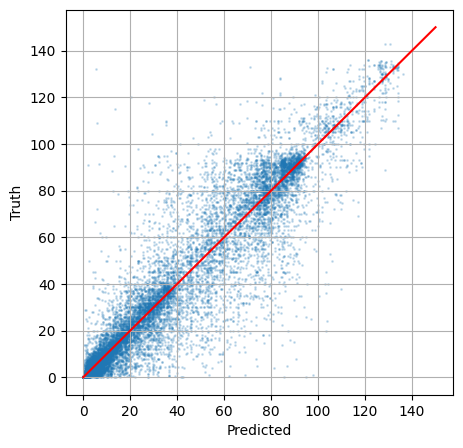

In [182]:
truth, preds = nFoldCrossValidation(x_train,y_train,best_reg_tree,kf)
evaluateRegression(truth,preds)
plotResults(preds,truth,150)

### Regression using linear models
#### Linear Regression

The RVE is:  0.7354145652424204
The rmse is:  17.5758831489271
The Correlation Score is is: 0.8576 (p-value=0.000000e+00)

The Maximum Error is is:  115.82455429440324
The Mean Absolute Error is:  13.322810636333777


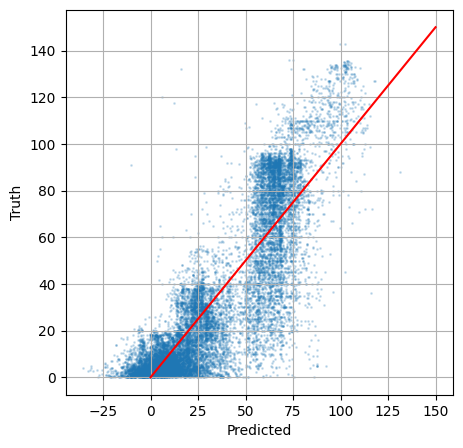

In [183]:
truth, preds = nFoldCrossValidation(x_train,y_train,LinearRegression(),kf)
evaluateRegression(truth,preds)
plotResults(preds,truth,150)

### Regularized Models
#### Lasso Regression
##### Evaluate alpha values and selection

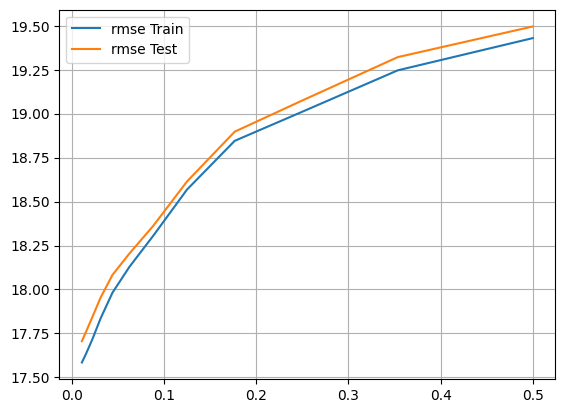

The RVE is:  0.7314300354299405
The rmse is:  17.707731315424827
The Correlation Score is is: 0.8553 (p-value=0.000000e+00)

The Maximum Error is is:  113.99993669520549
The Mean Absolute Error is:  13.411838300790771


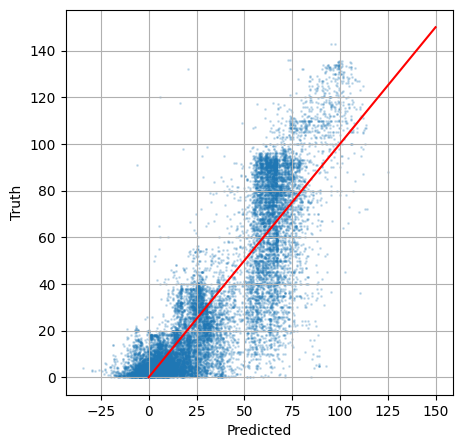

In [184]:
evaluateLassoAlphas(x_train,y_train)
#After evaluating we found that the best alpha value is 0.015625 
truth, preds = nFoldCrossValidation(x_train,y_train,Lasso(alpha=0.015625,max_iter=1000000),kf)
evaluateRegression(truth,preds)
plotResults(preds,truth,150)

#### Ridge Regression
##### Evaluate alpha values and selection

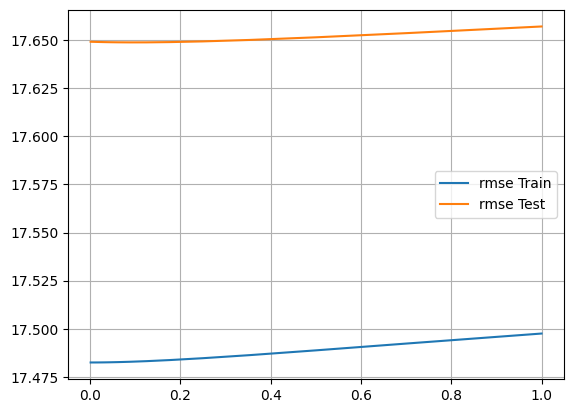

In [9]:
evaluateRidgeAlphas(x_train,y_train) # verify ridge mean squared errors

The RVE is:  0.7354145652424238
The rmse is:  17.575883148926994
The Correlation Score is is: 0.8576 (p-value=0.000000e+00)

The Maximum Error is is:  115.82455429442801
The Mean Absolute Error is:  13.322810636333717


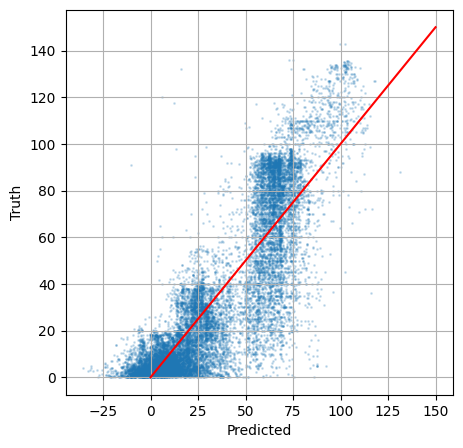

In [12]:
truth, preds = nFoldCrossValidation(x_train,y_train,Ridge(alpha=0.0, max_iter=100000),kf)
evaluateRegression(truth,preds)
plotResults(preds,truth,150)

#### Objective 1 - Best Regression Model Validation Using IVS and Simple Regression Validation

The RVE is:  0.8860000596997538
The rmse is:  11.682298010575712
The Correlation Score is is: 0.9416 (p-value=0.000000e+00)

The Maximum Error is is:  119.4
The Mean Absolute Error is:  6.451169653404723


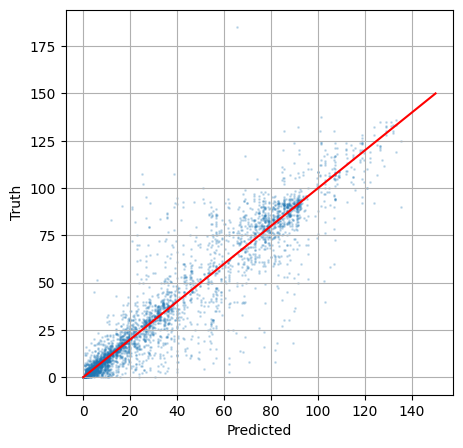

In [15]:
#TEST IVS DECISION TREE CLASSIFIER

bestParametersObtained = {'max_depth': 30, 'min_samples_leaf': 5, 'min_samples_split': 20}
modelValidation = DecisionTreeRegressor(**bestParametersObtained)
modelValidation.fit(x_train, y_train)
preds_ivs_obj2=modelValidation.predict(x_ivs)
evaluateRegression(y_ivs,preds_ivs_obj2)
plotResults(preds_ivs_obj2,y_ivs,150)

# Objective 2
#### Data Preparation

In [19]:
df_obj2 = pd.read_csv("HA1-DatasetScaled.tsv", sep="\t")

# Split the data into features (X) and the target variable (y)

x_obj2 = df.drop("critical_temp", axis=1)
y_obj2 = df["critical_temp"].apply(lambda x : 1 if x >= 80 else 0)

# Split the data into training and IVS sets
x_train_obj2, x_ivs_obj2, y_train_obj2, y_ivs_obj2= train_test_split(x_obj2, y_obj2, test_size=0.20, random_state=20)

kf_obj2 = KFold(n_splits=5, shuffle=True, random_state=83)

### Decision Tree Classifier
#### Fitting and N-Fold Cross validation

In [188]:
param_grid_class_tree= [
    {"max_depth" : [5,10,20,30],
    "min_samples_leaf" : [1,4,5,6,10],
    "min_samples_split" : [2,5,10,20],
    "criterion":['gini','entropy']}]

# Perform a grid search for hyperparameter tuning
grid_search_class_tree = GridSearchCV(DecisionTreeClassifier(), param_grid_class_tree
                                      , scoring='neg_mean_squared_error', cv=kf_obj2,n_jobs=-1)
grid_search_class_tree.fit(x_train_obj2, y_train_obj2)
# Get the best hyperparameters from the grid search
print(grid_search_class_tree.best_params_)
# Train the model with the best hyperparameters
best_regressor_class_tree = DecisionTreeClassifier(**grid_search_class_tree.best_params_)
best_regressor_class_tree.fit(x_train_obj2, y_train_obj2)

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}


DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=5)

#### Decision Tree Classifier - Statistic and Confusion Matrix Visualization  

In [20]:
bestParamsTreeClass = {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}
best_class_tree = DecisionTreeClassifier(**bestParamsTreeClass)
evaluateClassification(*nFoldCrossValidation(x_train_obj2,y_train_obj2,best_class_tree,kf_obj2))

The Precision is:  0.7823
The accuracy score is:  0.9279
The Recall is:  0.7969
The F1 score is:  0.7895
The Matthews correlation coefficient is:  0.7460

This is the Confusion Matrix
       0     1
0  13425   638
1    584  2292


#### Linear Models for Classification - Logistic Regressor

In [22]:
#Data preparation for logistic regression
scaler = StandardScaler()
scaler.fit(x_train)
X_train_scaled = pd.DataFrame(scaler.transform(x_train_obj2), columns=x_train_obj2.columns)
X_ivs_scaled = pd.DataFrame(scaler.transform(x_ivs_obj2), columns=x_ivs_obj2.columns)

params = [
    {"C" : [x*0.1 for x in range(1,11)],
    "max_iter" : [1000000]}]

grid_search_log = GridSearchCV(LogisticRegression(), params, scoring='f1', cv=kf,n_jobs=-1)
grid_search_log.fit(X_train_scaled, y_train_obj2)

# Get the best hyperparameters from the grid search
print(grid_search_log.best_params_)



mdl= LogisticRegression(**grid_search_log.best_params_,random_state=0).fit(X_train_scaled, y_train_obj2)
preds = mdl.predict(x_train_obj2)
evaluateClassification(y_train_obj2, preds)

{'C': 1.0, 'max_iter': 1000000}
The Precision is:  0.7056
The accuracy score is:  0.8936
The Recall is:  0.6408
The F1 score is:  0.6716
The Matthews correlation coefficient is:  0.6094

This is the Confusion Matrix
       0     1
0  13294   769
1   1033  1843


#### Objective 2 - Best Classifier Model Validation Using IVS and Binary Classification Validation

In [21]:
best_class_tree.fit(x_train_obj2, y_train_obj2)
preds_ivs_obj2=best_class_tree.predict(x_ivs_obj2)
evaluateClassification(y_ivs_obj2,preds_ivs_obj2)

The Precision is:  0.7781
The accuracy score is:  0.9322
The Recall is:  0.8024
The F1 score is:  0.7901
The Matthews correlation coefficient is:  0.7498

This is the Confusion Matrix
      0    1
0  3408  154
1   133  540
